<a href="https://colab.research.google.com/github/varun-bhaseen/Advance-Deep-Learning/blob/master/Assignment_2_low_level_Tensorflow_code%2C_State_of_art_augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment-2 Part-2 Image Augmentations techniques

## 1. Importing the Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## 2. Downloading the dataset:

### 2.1. Loading the dataset
The dataset we are using is tf_flower dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


### 2.2. Checking the classes of Dataset:

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


###2.3. Retriving the dataset:

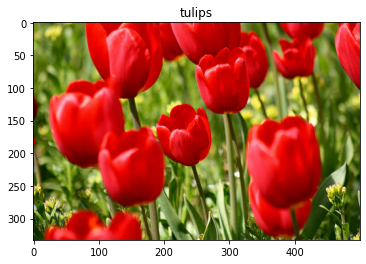

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

##3. Augmentation Techniques

###3.1. Resizing and Rescaling

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

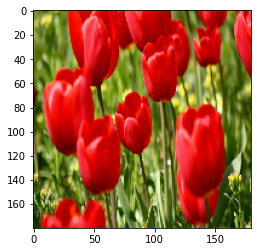

In [6]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
# Checking the pixel values

print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### 3.3. Keras Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

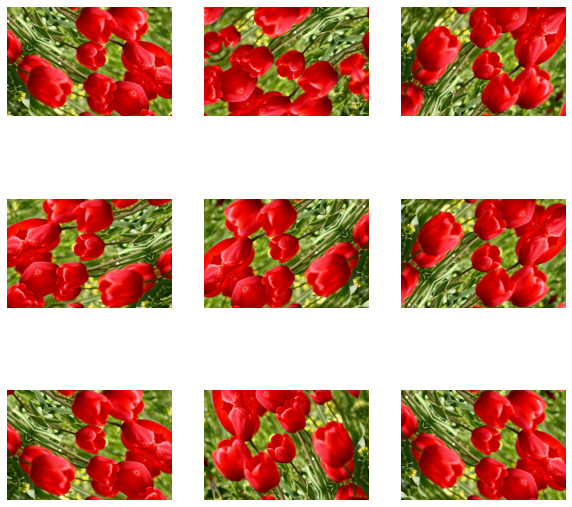

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### 3.4. Preprocessing layer

Make the preprocessing layers part of model

In [11]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

In [12]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

###3.5. Applying mix match to dataset

In [13]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)


In [14]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

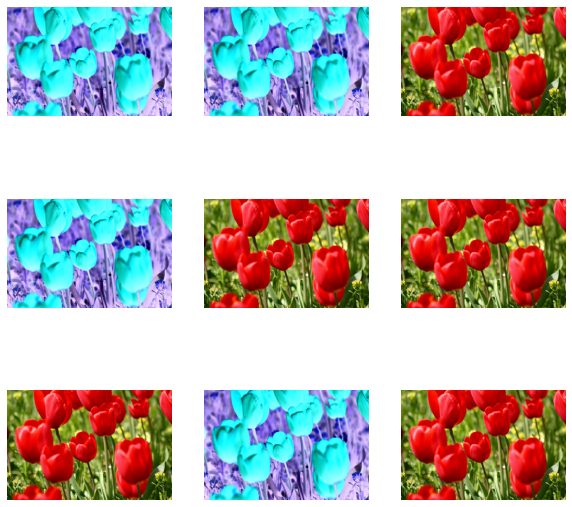

In [15]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert_img(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### 3.6. Color Invertion Augmentation

In [16]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

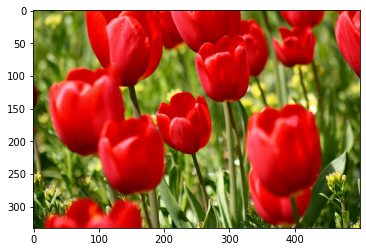

In [17]:
_ = plt.imshow(RandomInvert()(image)[0])

###3.7. Grayscale the image

In [18]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

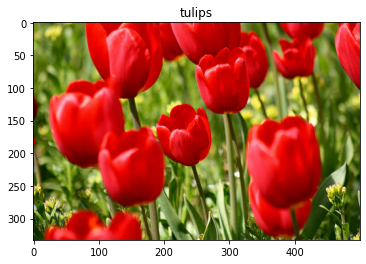

In [19]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [20]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

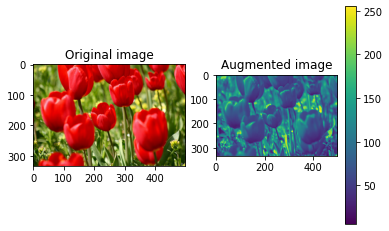

In [21]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

###3.8. Saturate Image

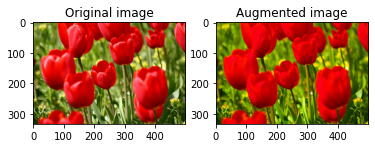

In [22]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

###3.9. Changing brightness

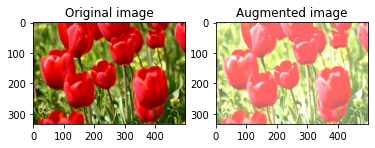

In [23]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

# Assignment-2 Part 1 Low Level Tensorflow Code:

In this assignment we need to use gradient tape and low level tensorflow code (do not use keras) to build a linear classifier

## 1. Importing the libraries as required

In [24]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image

# from tensorflow.examples.tutorials.mnist import input_data
# import input_data

import tensorflow_datasets as tfds
# from tensorflow_datasets.image_classification import MNIST
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys

## 2. Data Dimension
Let us use MNIST dataset for creating the classifier. The dimention of MNIST is 28*28 pixels of image with 10 classes. We will flatten the image to process it for the classifier

In [25]:
# img_h = img_w = 28             # MNIST images are 28x28
# img_size_flat = img_h * img_w  # 28x28=784, the total number of pixels
# n_classes = 10                 # Number of classes, one class per digit

# batch_size = 32                # Flower Dataset
# img_height = img_width = 180   # Image height of flower dataset                

## 3. Functions to Load dataset

we'll write the function which automatically loads the MNIST data and returns it in our desired shape and format. 

Here, we'll simply write a function (load_data) which has two modes: train (which loads the training and validation images and their corresponding labels) and test (which loads the test images and their corresponding labels)

Link to Load data: https://www.tensorflow.org/tutorials/load_data/images

### 3.1. Loading MNIST dataset

In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load('mnist', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                  with_info=True, as_supervised=True,)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [27]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

10


In [28]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))

# plt.imshow(image, interpolation='nearest')
# plt.show()

# _ = plt.imshow(image)
# _ = plt.title(get_label_name(label))
image

<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],


In [29]:
image_batch, label_batch = next(iter(train_ds))

# image_batch [0]

# plt.figure(figsize=(28, 28))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i], cmap= 'gray')
#   label = label_batch[i]
#   plt.title(class_names[label])
#   plt.axis("off")

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [32]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

### 3.2. Loading flower dataset

In [33]:
# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url, 
#                                    fname='flower_photos', 
#                                    untar=True)
# data_dir = pathlib.Path(data_dir)

In [34]:
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

In [35]:
# list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [36]:
# for f in list_ds.take(5):
#   print(f.numpy())

In [37]:
# class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
# print(class_names)

In [38]:
# val_size = int(image_count * 0.2)
# train_ds = list_ds.skip(val_size)
# val_ds = list_ds.take(val_size)

In [39]:
# print(tf.data.experimental.cardinality(train_ds).numpy())
# print(tf.data.experimental.cardinality(val_ds).numpy())

In [40]:
# def get_label(file_path):
#   # convert the path to a list of path components
#   parts = tf.strings.split(file_path, os.path.sep)
#   # The second to last is the class-directory
#   one_hot = parts[-2] == class_names
#   # Integer encode the label
#   return tf.argmax(one_hot)

In [41]:
# def decode_img(img):
#   # convert the compressed string to a 3D uint8 tensor
#   img = tf.image.decode_jpeg(img, channels=3)
#   # resize the image to the desired size
#   return tf.image.resize(img, [img_height, img_width])

In [42]:
# def process_path(file_path):
#   label = get_label(file_path)
#   # load the raw data from the file as a string
#   img = tf.io.read_file(file_path)
#   img = decode_img(img)
#   return img, label

In [43]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [45]:
# for image, label in train_ds.take(1):
#   print("Image shape: ", image.numpy().shape)
#   print("Label: ", label.numpy())

In [46]:
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

# train_ds = configure_for_performance(train_ds)
# val_ds = configure_for_performance(val_ds)

In [47]:
# image_batch, label_batch = next(iter(train_ds))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"))
#   label = label_batch[i]
#   plt.title(class_names[label])
#   plt.axis("off")

### 3.3. Functions to Load the dataset

In [48]:
# # def load_data(mode='train'):
# #     """
# #     Function to (download and) load the MNIST data
# #     :param mode: train or test
# #     :return: images and the corresponding labels
# #     """
# #     # import tensorflow_datasets as tfds
    
# #     ds = tfds.load('mnist', split='train', shuffle_files=True, as_supervised = True)
    
    
# #     if mode == 'train':
# #         x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
# #                                              mnist.validation.images, mnist.validation.labels
# #         return x_train, y_train, x_valid, y_valid
# #     elif mode == 'test':
# #         x_test, y_test = mnist.test.images, mnist.test.labels
# #     return x_test, y_test

# def randomize(x, y):
#     """ Randomizes the order of data samples and their corresponding labels"""
#     permutation = np.random.permutation(y.shape[0])
#     shuffled_x = x[permutation, :]
#     shuffled_y = y[permutation]
#     return shuffled_x, shuffled_y

# def get_next_batch(x, y, start, end):
#     x_batch = x[start:end]
#     y_batch = y[start:end]
#     return x_batch, y_batch

In [49]:
# print("Size of:")
# print(f"- Training-set:\t{train_ds.shape}")
# print(f"- Validation-set:\t{val_ds.shape}")
# # print('x_train:\t{}'.format(x_train.shape))
# # print('y_train:\t{}'.format(y_train.shape))
# # print('x_train:\t{}'.format(x_valid.shape))
# # print('y_valid:\t{}'.format(y_valid.shape))

In [50]:
# train

## 4. Creating Neural Network:

create network by defining proper tensors to feed in the input values to the model

In [51]:
def build_model(width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [52]:
def step(X, y):
	# keep track of our gradients
	with tf.GradientTape() as tape:
		# make a prediction using the model and then calculate the
		# loss
		pred = model(X)
		loss = categorical_crossentropy(y, pred)
	# calculate the gradients using our tape and then update the
	# model weights
	grads = tape.gradient(loss, model.trainable_variables)
	opt.apply_gradients(zip(grads, model.trainable_variables))

In [53]:
# initialize the number of epochs to train for, batch size, and
# initial learning rate
EPOCHS = 25
BS = 64
INIT_LR = 1e-3
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# one-hot encode the labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step


In [54]:
# build our model and initialize our optimizer
print("[INFO] creating model...")
model = build_model(28, 28, 1, 10)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

[INFO] creating model...


In [55]:
# # Create the graph for the linear model
# # Placeholders for inputs (x) and outputs(y)
# x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
# y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

In [56]:
# # Create weight matrix initialized randomely from N~(0, 0.01)
# W = weight_variable(shape=[img_size_flat, n_classes])

# # Create bias vector initialized as zero
# b = bias_variable(shape=[n_classes])

# output_logits = tf.matmul(x, W) + b

In [57]:
# # Define the loss function, optimizer, and accuracy
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
# correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# # Model predictions
# cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

In [58]:
# # Creating the op for initializing all variables
# init = tf.global_variables_initializer()

## 6. Training

In [59]:
# compute the number of batch updates per epoch
numUpdates = int(trainX.shape[0] / BS)
# loop over the number of epochs
for epoch in range(0, EPOCHS):
	# show the current epoch number
	print("[INFO] starting epoch {}/{}...".format(
		epoch + 1, EPOCHS), end="")
	sys.stdout.flush()
	epochStart = time.time()
	# loop over the data in batch size increments
	for i in range(0, numUpdates):
		# determine starting and ending slice indexes for the current
		# batch
		start = i * BS
		end = start + BS
		# take a step
		step(trainX[start:end], trainY[start:end])
	# show timing information for the epoch
	epochEnd = time.time()
	elapsed = (epochEnd - epochStart) / 60.0
	print("took {:.4} minutes".format(elapsed))

[INFO] starting epoch 1/25...took 0.3724 minutes
[INFO] starting epoch 2/25...took 0.2793 minutes
[INFO] starting epoch 3/25...took 0.2759 minutes
[INFO] starting epoch 4/25...took 0.2771 minutes
[INFO] starting epoch 5/25...took 0.2707 minutes
[INFO] starting epoch 6/25...took 0.2815 minutes
[INFO] starting epoch 7/25...took 0.2759 minutes
[INFO] starting epoch 8/25...took 0.2703 minutes
[INFO] starting epoch 9/25...took 0.2713 minutes
[INFO] starting epoch 10/25...took 0.2708 minutes
[INFO] starting epoch 11/25...took 0.2697 minutes
[INFO] starting epoch 12/25...took 0.2736 minutes
[INFO] starting epoch 13/25...took 0.2815 minutes
[INFO] starting epoch 14/25...took 0.2733 minutes
[INFO] starting epoch 15/25...took 0.2731 minutes
[INFO] starting epoch 16/25...took 0.2696 minutes
[INFO] starting epoch 17/25...took 0.2701 minutes
[INFO] starting epoch 18/25...took 0.2682 minutes
[INFO] starting epoch 19/25...took 0.2714 minutes
[INFO] starting epoch 20/25...took 0.2721 minutes
[INFO] st

In [60]:
# # Create an interactive session (to keep the session in the other cells)
# sess = tf.InteractiveSession()
# # Initialize all variables
# sess.run(init)
# # Number of training iterations in each epoch
# num_tr_iter = int(len(y_train) / batch_size)
# for epoch in range(epochs):
#     print('Training epoch: {}'.format(epoch + 1))
#     # Randomly shuffle the training data at the beginning of each epoch 
#     x_train, y_train = randomize(x_train, y_train)
#     for iteration in range(num_tr_iter):
#         start = iteration * batch_size
#         end = (iteration + 1) * batch_size
#         x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

#         # Run optimization op (backprop)
#         feed_dict_batch = {x: x_batch, y: y_batch}
#         sess.run(optimizer, feed_dict=feed_dict_batch)

#         if iteration % display_freq == 0:
#             # Calculate and display the batch loss and accuracy
#             loss_batch, acc_batch = sess.run([loss, accuracy],
#                                              feed_dict=feed_dict_batch)

#             print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
#                   format(iteration, loss_batch, acc_batch))

#     # Run validation after every epoch
#     feed_dict_valid = {x: x_valid[:1000], y: y_valid[:1000]}
#     loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
#     print('---------------------------------------------------------')
#     print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
#           format(epoch + 1, loss_valid, acc_valid))
#     print('---------------------------------------------------------')

## 7. Testing

In [61]:
# in order to calculate accuracy using Keras' functions we first need
# to compile the model
model.compile(optimizer=opt, loss=categorical_crossentropy,
	metrics=["acc"])
# now that the model is compiled we can compute the accuracy
(loss, acc) = model.evaluate(testX, testY)
print("[INFO] test accuracy: {:.4f}".format(acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.0642 - acc: 0.9893
[INFO] test accuracy: 0.9893


In [62]:
# # Test the network after training
# # Accuracy
# x_test, y_test = load_data(mode='test')
# feed_dict_test = {x: x_test[:1000], y: y_test[:1000]}
# loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
# print('---------------------------------------------------------')
# print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
# print('---------------------------------------------------------')

##8. Visualizing the output

In [63]:
# def plot_images(images, cls_true, cls_pred=None, title=None):
#     """
#     Create figure with 3x3 sub-plots.
#     :param images: array of images to be plotted, (9, img_h*img_w)
#     :param cls_true: corresponding true labels (9,)
#     :param cls_pred: corresponding true labels (9,)
#     """
#     fig, axes = plt.subplots(3, 3, figsize=(9, 9))
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)
#     for i, ax in enumerate(axes.flat):
#         # Plot image.
#         ax.imshow(images[i].reshape(28, 28), cmap='binary')

#         # Show true and predicted classes.
#         if cls_pred is None:
#             ax_title = "True: {0}".format(cls_true[i])
#         else:
#             ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

#         ax.set_title(ax_title)

#         # Remove ticks from the plot.
#         ax.set_xticks([])
#         ax.set_yticks([])

#     if title:
#         plt.suptitle(title, size=20)
#     plt.show(block=False)

# def plot_example_errors(images, cls_true, cls_pred, title=None):
#     """
#     Function for plotting examples of images that have been mis-classified
#     :param images: array of all images, (#imgs, img_h*img_w)
#     :param cls_true: corresponding true labels, (#imgs,)
#     :param cls_pred: corresponding predicted labels, (#imgs,)
#     """
#     # Negate the boolean array.
#     incorrect = np.logical_not(np.equal(cls_pred, cls_true))

#     # Get the images from the test-set that have been
#     # incorrectly classified.
#     incorrect_images = images[incorrect]

#     # Get the true and predicted classes for those images.
#     cls_pred = cls_pred[incorrect]
#     cls_true = cls_true[incorrect]

#     # Plot the first 9 images.
#     plot_images(images=incorrect_images[0:9],
#                 cls_true=cls_true[0:9],
#                 cls_pred=cls_pred[0:9],
#                 title=title)

In [64]:
# # Plot some of the correct and misclassified examples
# cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
# cls_true = np.argmax(y_test[:1000], axis=1)
# plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
# plot_example_errors(x_test[:1000], cls_true, cls_pred, title='Misclassified Examples')
# plt.show()

In [ ]:
# sess.close()